In [6]:
import numpy as np
import scipy.sparse


def get_data(file, isM = False):
    if isM:
        return np.loadtxt(file)[:, 1]
    matrix = scipy.sparse.load_npz(file).todense()
    return np.array(matrix).reshape(1000, 20, 20, 100)

In [8]:
# put files in "data" directory because some extra files are created while
# running the notebook
# file starting with b are signal, e for background
from pathlib import Path

folder = Path("./data")

data_sig_l = []
#m_sig = []
data_bkg_l = []
#m_bkg = []
for file in folder.iterdir():
    # signal files
    is_signal = file.name[0] == "b"
    is_background = file.name[0] == "e"
    if is_signal:
        if file.suffix == ".npz":
            data_sig_l.append(get_data(file))
#         elif not file.suffix:
#             m_sig.append(get_data(file, isM=True))
    # background files
    elif is_background:
        if file.suffix == ".npz":
            data_bkg_l.append(get_data(file))
#         elif not file.suffix:
#             m_bkg.append(get_data(file, isM=True))


data_sig_l = np.concatenate(data_sig_l, axis=0)
#m_sig = np.concatenate(m_sig, axis=0)
data_bkg_l = np.concatenate(data_bkg_l, axis=0)
#m_bkg = np.concatenate(m_bkg, axis=0)

print(f"Signal shapes data: {data_sig_l.shape}")
print(f"Background shapes data: {data_bkg_l.shape}")

Signal shapes data: (10000, 20, 20, 100)
Background shapes data: (10000, 20, 20, 100)


<Figure size 3600x7200 with 0 Axes>

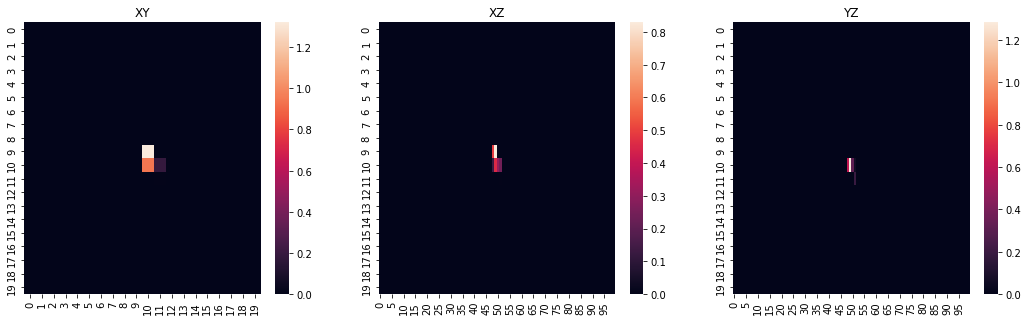

In [11]:
# Plot di un evento
import matplotlib.pylab as plt
import seaborn as sns

plt.figure(figsize=(50, 100))
fig, (axs) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(18)

n = 1  # plot dell'n-esimo evento
dataZ = data_bkg_l.sum(3)
dataY = data_bkg_l.sum(2)
dataX = data_bkg_l.sum(1)

# dataZ = data_sig_l.sum(3)
# dataY = data_sig_l.sum(2)
# dataX = data_sig_l.sum(1)

gz = sns.heatmap(dataZ[n], annot=False, ax=axs[0])
gz.set_title("XY")

gy = sns.heatmap(dataY[n], annot=False, ax=axs[1])
gy.set_title("XZ")

gx = sns.heatmap(dataX[n], annot=False, ax=axs[2])
gx.set_title("YZ")


plt.show()

In [107]:
def build_features(data):
# 22 features are hits (the j-th feature is put to 0 if nhits < j), 23th features is the total number of hits
    nmax = 22 # max number of hits encountered
    feats = np.zeros((nmax+1, data.shape[0]))
    for i, particle in enumerate(data):
        coords = np.argwhere(particle)   
        n = coords.shape[0]

        en = np.zeros(n)  
        for j in range(0, n):
            en[j] = particle[coords[j,0], coords[j, 1], coords[j, 2]]
        z = np.zeros(nmax-n)
        feats[:-1, i] = np.concatenate((en, z))
        feats[-1, i] = n
    return feats

In [108]:
# both function calls take 3.2s (~28x speedup)
feats_sig = build_features(data_sig_l)
feats_bkg = build_features(data_bkg_l)

<Figure size 3600x7200 with 0 Axes>

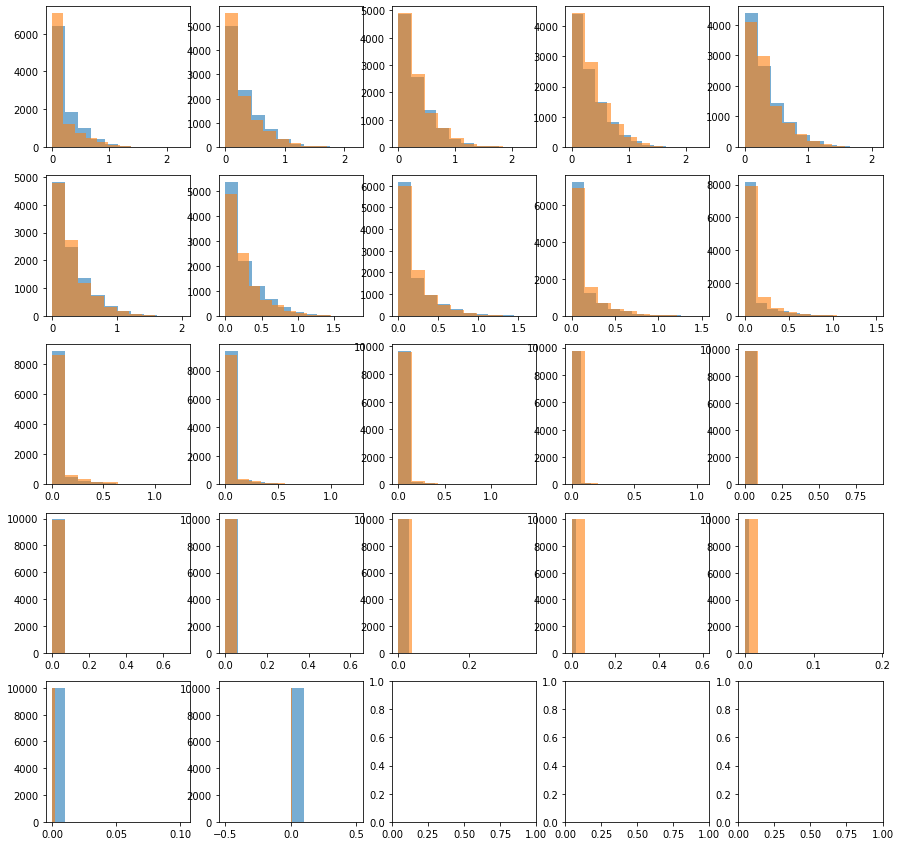

In [109]:
ncols = 5
nrows = 5

plt.figure(figsize=(50, 100))
fig, (axs) = plt.subplots(nrows, ncols)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(ncols):
    for j in range(nrows):
        ij = i * ncols + j
        if ij == 22:
            break
        axs[i, j].hist(feats_sig[ij], alpha=0.6)
        axs[i, j].hist(feats_bkg[ij], alpha = 0.6)

C:\Users\moret\Desktop\TESI\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\moret\Desktop\TESI\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


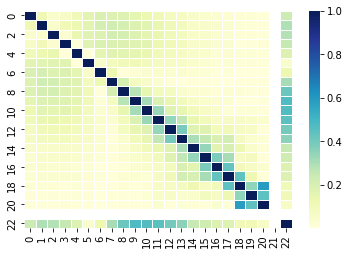

In [110]:
# Linear correlation (Pearson) matrix (only for signals)
corr = np.corrcoef((feats_sig))

ax = sns.heatmap(np.abs(corr), linewidth=0.5, cmap="YlGnBu")
plt.show()

In [111]:
# Preparing the dataset for SVM
data = np.concatenate([feats_sig, feats_bkg], axis=1).T
#labels = np.concatenate([feats_sig[-1], feats_bkg[-1]], axis=0).T
labels = np.concatenate((np.ones(feats_sig.shape[1]), np.zeros(feats_bkg.shape[1])))
print(data.shape, labels.shape)

(20000, 23) (20000,)


In [112]:
# mutual information of each feature
from sklearn.feature_selection import mutual_info_classif

mutual_info_classif(data, labels)

array([0.04183832, 0.01809958, 0.00486645, 0.01311487, 0.00453653,
       0.00865863, 0.00247691, 0.00323168, 0.00605399, 0.00937988,
       0.00643386, 0.00766649, 0.00673783, 0.00618349, 0.        ,
       0.        , 0.00704676, 0.        , 0.        , 0.00016406,
       0.00045142, 0.0020558 , 0.00837841])

In [113]:
# Train and test splitting, training and testing the SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA

sample_train, sample_test, label_train, label_test = train_test_split(
    data, labels, test_size=0.9, train_size=0.1
)

# PCA with n_dim principal components
do_PCA = False
if do_PCA:
    n_dim = 10
    pca = PCA(n_components=n_dim).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

classical_kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print("%s kernel classification test score:  %0.4f" % (kernel, classical_score))

linear kernel classification test score:  0.5603
poly kernel classification test score:  0.5571
rbf kernel classification test score:  0.5545
sigmoid kernel classification test score:  0.4482


In [116]:
# CNN approach
from tensorflow.keras.utils import to_categorical

data_sigY = np.expand_dims(data_sig_l.sum(2), 3)
data_bkgY = np.expand_dims(data_bkg_l.sum(2), 3)

data_sigX = np.expand_dims(data_sig_l.sum(1), 3)
data_bkgX = np.expand_dims(data_bkg_l.sum(1), 3)

dataYX_sig = np.concatenate([data_sigY, data_sigX], axis=3)
dataYX_bkg = np.concatenate([data_bkgY, data_bkgX], axis=3)
data = np.concatenate([dataYX_bkg, dataYX_sig], axis=0)

# Note background label 0 and signal label 1
labels = np.concatenate([np.zeros(dataYX_bkg.shape[0]), np.ones(dataYX_sig.shape[0])])

sample_train, sample_test, label_train, label_test = train_test_split(
    data, labels, test_size=0.2, train_size=0.8
)
label_train = to_categorical(label_train)
label_test = to_categorical(label_test)
print(f"Train: data of shape {sample_train.shape}, labels of shape {label_train.shape}")
print(f"Test: data of shape {sample_test.shape}, labels of shape {label_test.shape}")

Train: data of shape (16000, 20, 100, 2), labels of shape (16000, 2)
Test: data of shape (4000, 20, 100, 2), labels of shape (4000, 2)


In [117]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU

# CNN architecture

batch_size = 400
epochs = 40
num_classes = 2
learning_rate = 0.05

fashion_model = Sequential()
fashion_model.add(
    Conv2D(32, kernel_size=(4, 4), input_shape=(20, 100, 2), padding="same")
)
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2), padding="same"))
fashion_model.add(Conv2D(12, kernel_size=(3, 3)))
fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# fashion_model.add(Conv2D(6, kernel_size=(2, 2),activation='linear'))
# fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2), padding="same"))
fashion_model.add(Flatten())
fashion_model.add(Dense(3))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(Dense(num_classes, activation="softmax"))

fashion_model.compile(
    loss=categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"]
)
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 100, 32)       1056      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 100, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 48, 12)         3468      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 48, 12)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 24, 12)        0         
 2D)                                                    

In [118]:
# Training CNN (For 50 epochs it will take 3-4 minutes)
fashion_train = fashion_model.fit(
    sample_train, label_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/40
40/40 [==============================] - 19s 444ms/step - loss: 0.7828 - accuracy: 0.6971
Epoch 2/40
40/40 [==============================] - 18s 446ms/step - loss: 0.4257 - accuracy: 0.8134
Epoch 3/40
40/40 [==============================] - 18s 448ms/step - loss: 0.3706 - accuracy: 0.8475
Epoch 4/40
40/40 [==============================] - 18s 449ms/step - loss: 0.3476 - accuracy: 0.8569
Epoch 5/40
40/40 [==============================] - 18s 457ms/step - loss: 0.3279 - accuracy: 0.8671
Epoch 6/40
40/40 [==============================] - 18s 453ms/step - loss: 0.3308 - accuracy: 0.8654
Epoch 7/40
40/40 [==============================] - 19s 464ms/step - loss: 0.3121 - accuracy: 0.8724
Epoch 8/40
40/40 [==============================] - 18s 453ms/step - loss: 0.3282 - accuracy: 0.8662
Epoch 9/40
40/40 [==============================] - 18s 449ms/step - loss: 0.2858 - accuracy: 0.8846
Epoch 10/40
40/40 [==============================] - 18s 451ms/step - loss: 0.2863 - accura

In [119]:
# Evaluating performances on test set
test_eval = fashion_model.evaluate(sample_test, label_test, verbose=0)
print("Test loss:", test_eval[0])
print("Test accuracy:", test_eval[1])

Test loss: 0.3323194980621338
Test accuracy: 0.8842499852180481
